## <center>Exploratory Data Analysis и линейная регрессия

In [1]:
import numpy as np
import folium
import pandas as pd  # your favorite data package
import matplotlib.pyplot as plt  # your favorite visualization package
import seaborn as sns

%matplotlib inline
sns.set(style="darkgrid")

np.random.seed(17)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [2]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
df.drop("dropoff_datetime", axis=1, inplace=True)

In [5]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df_test["pickup_datetime"] = pd.to_datetime(df_test["pickup_datetime"])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

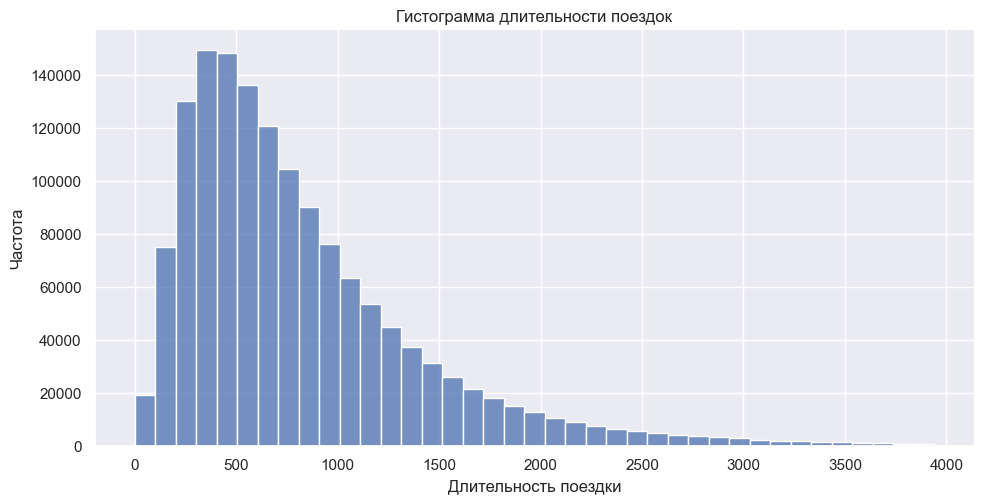

In [6]:
sns.displot(df['trip_duration'], bins=range(0, 4000, 101), aspect=2, kde=False)
plt.title('Гистограмма длительности поездок')
plt.xlabel('Длительность поездки')
plt.ylabel('Частота');

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений? \
Большинство значений тагрета > 300, целевая переменная распределена около нормально и смещена влево

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE? \
Чтобы модель была более устойчива к выбросам

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:
$$\hat{a}(x_i) = \log(a(x_i) + 1)$$
$$\text{MSE}(X, \hat{y}, \hat{a}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \hat{a}(x_i)\big)^2$$
$$\text{MSE}(X, \hat{y}, \hat{a}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2$$
$$\text{RMSLE}(X, y, a) = \sqrt{\text{MSE}(X, \hat{y}, \hat{a})}$$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [7]:
df["log_trip_duration"] = np.log1p(df["trip_duration"])

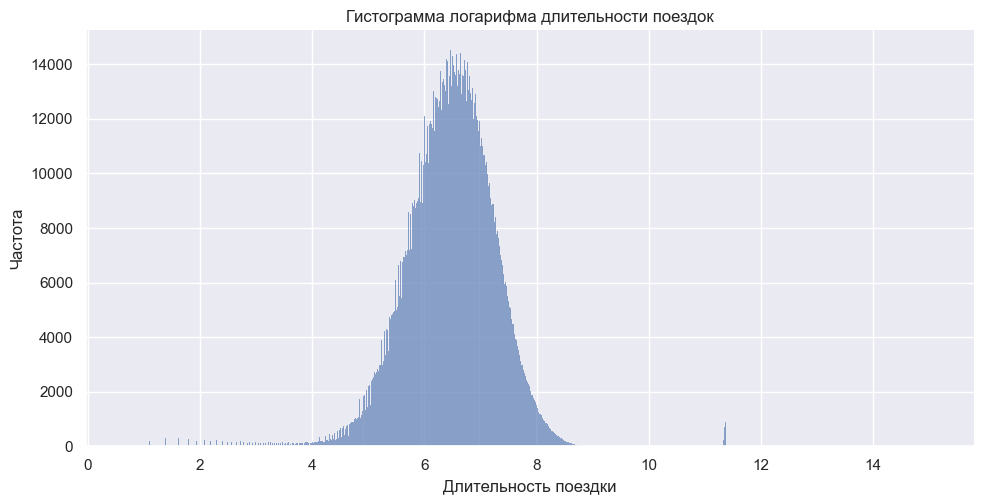

In [8]:
sns.displot(df['log_trip_duration'], aspect=2, kde=False)
plt.title('Гистограмма логарифма длительности поездок')
plt.xlabel('Длительность поездки')
plt.ylabel('Частота');

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [9]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))
    raise NotImplementedError

rmsle_best_const = rmsle(df["log_trip_duration"], df["log_trip_duration"].mean())
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

In [10]:
df["date"] = df['pickup_datetime'].dt.date
df["day_of_week"] = df['pickup_datetime'].apply(lambda x : x.weekday() + 1)
df["hour"] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month_name()

df_test["date"] = df_test['pickup_datetime'].dt.date
df_test["day_of_week"] = df_test['pickup_datetime'].apply(lambda x : x.weekday() + 1)
df_test["hour"] = df_test['pickup_datetime'].dt.hour
df_test['month'] = df_test['pickup_datetime'].dt.month_name()

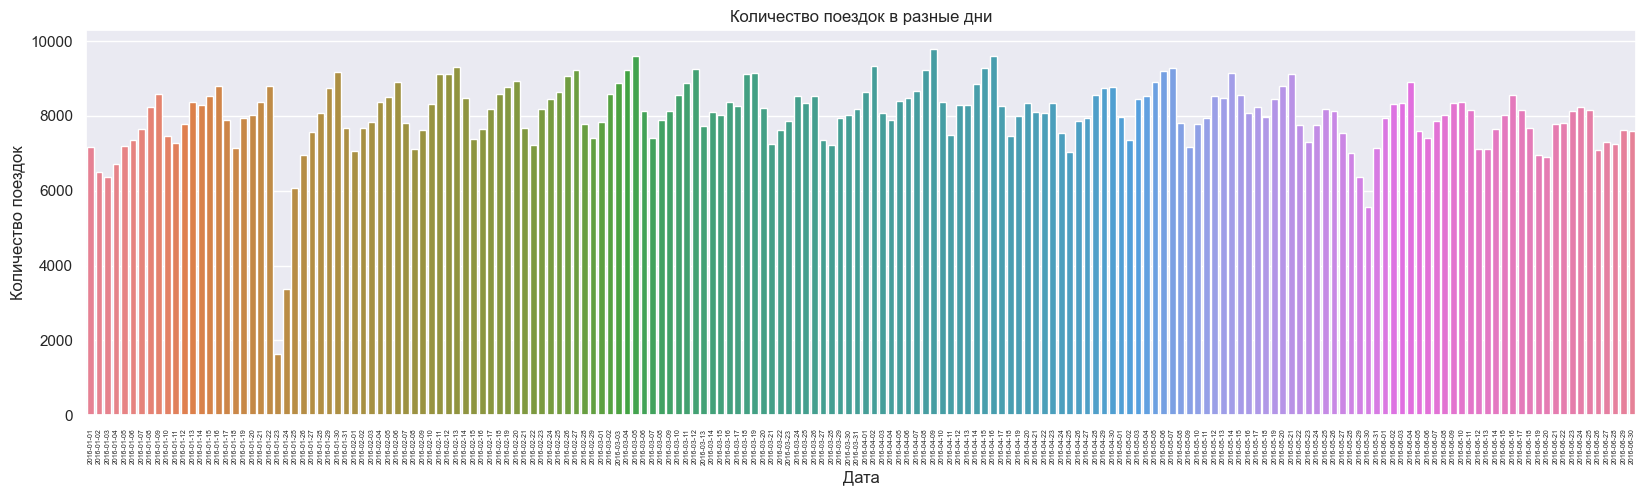

In [11]:
plt.figure(figsize=(20, 5))
sns.countplot(x="date", data=df.sort_values(by="date"), hue="date", legend=False)
plt.title('Количество поездок в разные дни')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.xticks(fontsize=5, rotation=90)
plt.show();

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

2016-01-23 власти запретили автомобильное движение в Нью-Йорке из-за снежной бури

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

In [12]:
df["date"].value_counts().sort_values().head(2)

date
2016-01-23    1648
2016-01-24    3383
Name: count, dtype: int64

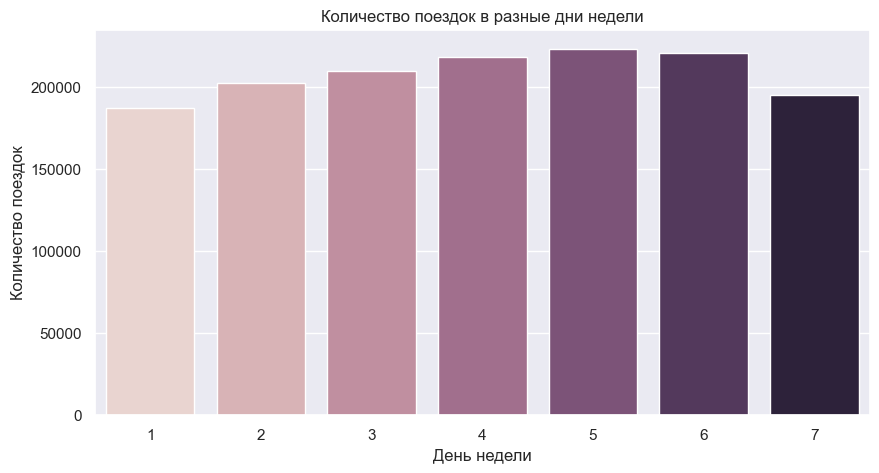

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot(x="day_of_week", data=df.sort_values(by="day_of_week"), hue="day_of_week", legend=False)
plt.title('Количество поездок в разные дни недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок');
# plt.xticks(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90) # Почему-то подписи вправо съезжают :(

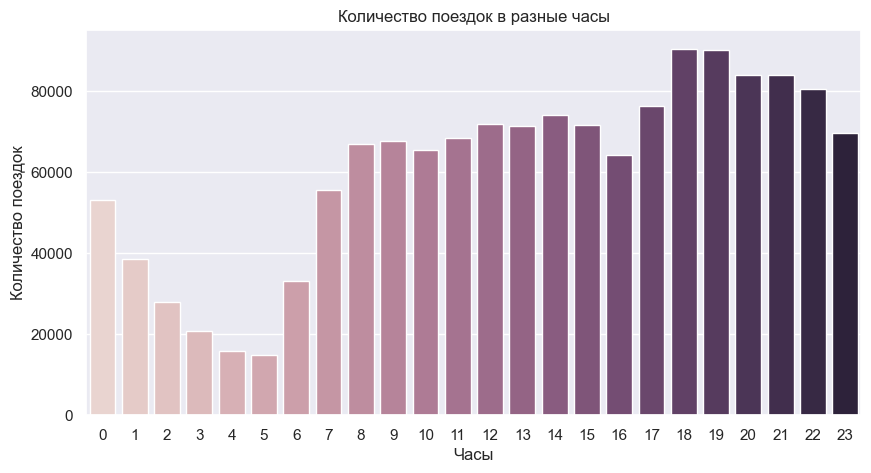

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(x="hour", data=df.sort_values(by="hour"), hue="hour", legend=False)
plt.title('Количество поездок в разные часы')
plt.xlabel('Часы')
plt.ylabel('Количество поездок');

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [15]:
df_mh = df.groupby(['month', 'hour'], as_index=False)['id'].count()

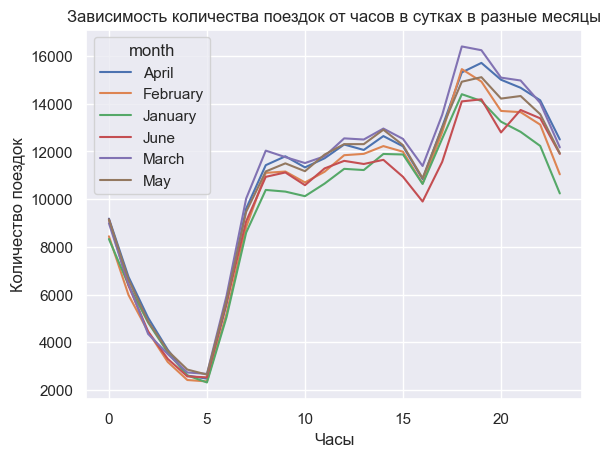

In [16]:
sns.lineplot(x="hour", y="id", data=df_mh, hue="month")
plt.title('Зависимость количества поездок от часов в сутках в разные месяцы')
plt.xlabel('Часы')
plt.ylabel('Количество поездок');

In [17]:
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df_test['day_of_week'] = df_test['pickup_datetime'].dt.day_name()
df_dh = df.groupby(['day_of_week', 'hour'], as_index=False)['id'].count()

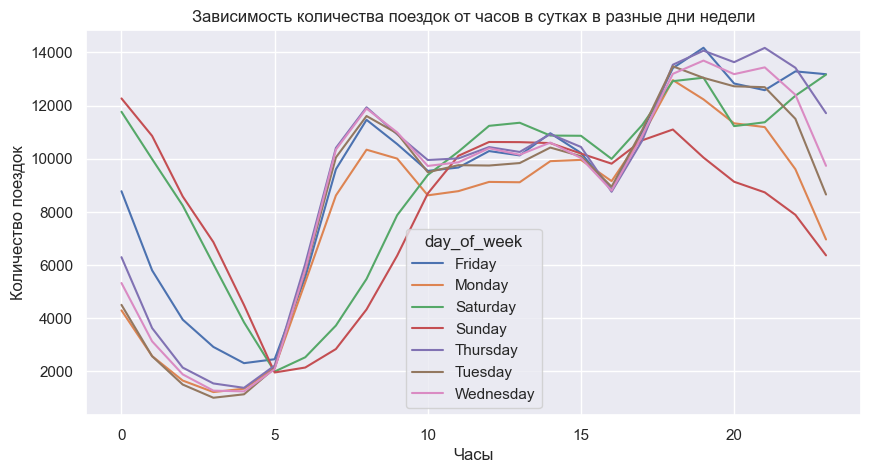

In [18]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="hour", y="id", data=df_dh, hue="day_of_week")
plt.title('Зависимость количества поездок от часов в сутках в разные дни недели')
plt.xlabel('Часы')
plt.ylabel('Количество поездок');

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?
1) Во все месяцы самое популярное время для поездки находится в интервале от 18:00 до 20:00. Возможно потому, что люди едут с работы в это время.
2) Наименее популярное время во все месяцы - это 05:00.
3) Для дней недели описанные выше выводы тоже подходят.
4) Поездки с 00:00 до 05:00 наиболее популярны в субботу и воскресенье.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
df["anomaly1"] = df["date"].apply(lambda d: 1 if d.month == 1 and d.day == 23 else 0)
df["anomaly2"] = df["date"].apply(lambda d: 1 if d.month == 1 and d.day == 24 else 0)
df_test["anomaly1"] = df_test["date"].apply(lambda d: 1 if d.month == 1 and d.day == 23 else 0)
df_test["anomaly2"] = df_test["date"].apply(lambda d: 1 if d.month == 1 and d.day == 24 else 0)

In [21]:
X_train, X_test = train_test_split(df, test_size=0.3, shuffle=True, random_state=17)

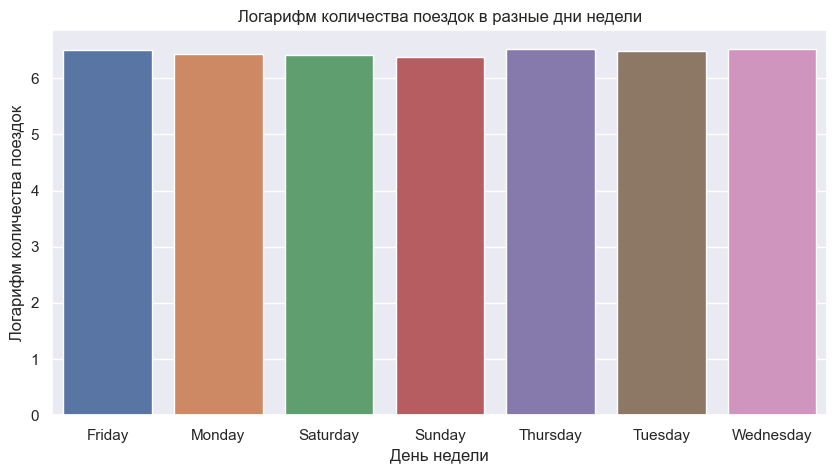

In [22]:
df_mean_log = X_train.groupby("day_of_week", as_index=False)["log_trip_duration"].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x="day_of_week", y="log_trip_duration", data=df_mean_log, hue="day_of_week", legend=False)
plt.title('Логарифм количества поездок в разные дни недели')
plt.xlabel('День недели')
plt.ylabel('Логарифм количества поездок');

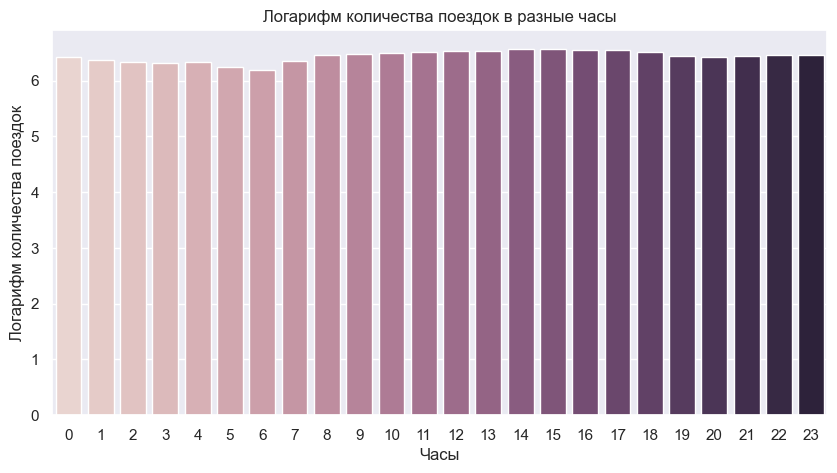

In [23]:
df_hour_mean_log = X_train.groupby("hour", as_index=False)["log_trip_duration"].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x="hour", y="log_trip_duration", data=df_hour_mean_log, hue="hour", legend=False)
plt.title('Логарифм количества поездок в разные часы')
plt.xlabel('Часы')
plt.ylabel('Логарифм количества поездок');

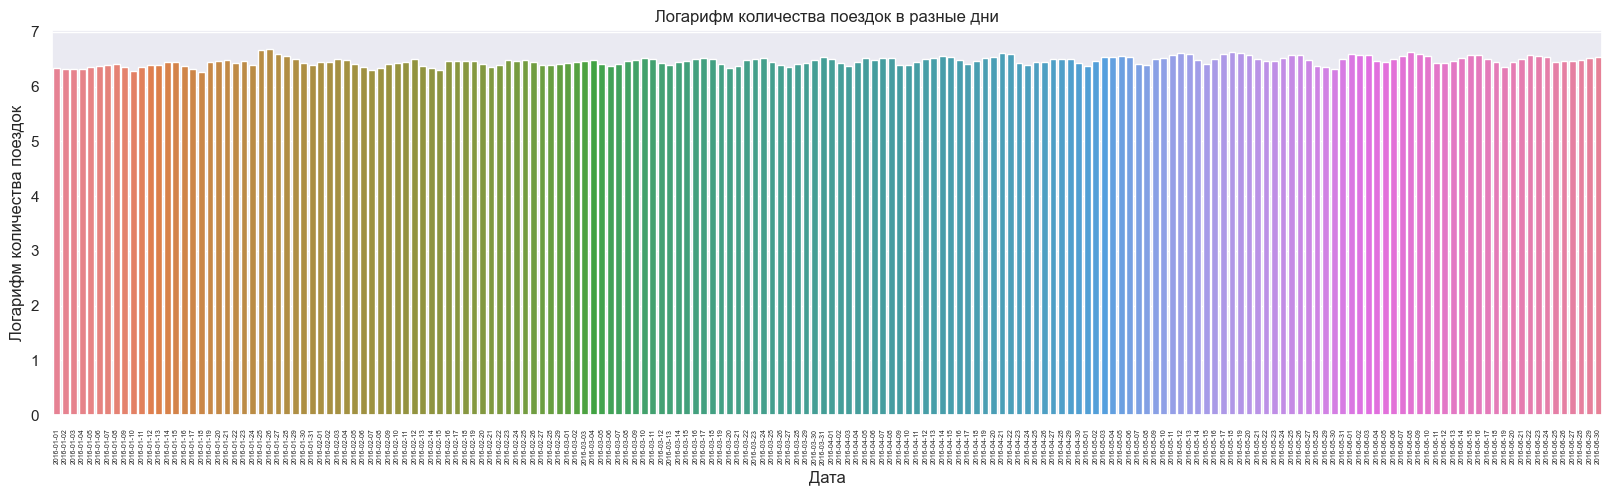

In [24]:
df_date_mean_log = X_train.groupby("date", as_index=False)["log_trip_duration"].mean()
plt.figure(figsize=(20, 5))
sns.barplot(x="date", y="log_trip_duration", data=df_date_mean_log.sort_values(by="date"), hue="date", legend=False)
plt.title('Логарифм количества поездок в разные дни')
plt.xlabel('Дата')
plt.ylabel('Логарифм количества поездок')
plt.xticks(fontsize=5, rotation=90)
plt.show();

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Графики зависимости таргета от дня недели и от часа в сутках почти константные из-за логарифма, в отличие от аналогичных графиков для количества поездок, где много локальных максимумов и минимумов. В два аномальных периода ничего не происходит из-за того, что мы смотрим на порядок величин, а не их абсолютное значение. График зависимости `log_trip_duration` от номера дня в году периодический.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Сделано ранее

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Категориальные**: vendor_id, pickup_datetime, store_and_fwd_flag, date, day_of_week, hour, month \
**Численные**: passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, \
trip_duration, log_trip_duration, anomaly1, anomaly2

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [25]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [26]:
y_train = X_train["log_trip_duration"]
y_test = X_test["log_trip_duration"]
X_train.drop("log_trip_duration", axis=1, inplace=True)

In [27]:
numeric = ["anomaly1", "anomaly2"]
categorical = ["date", "hour", "day_of_week", "month"]

# X_train[categorical].isna().sum().sum() # == 0
column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)]) # думаю, что нет смысла масштабировать индикаторы, но ладно

pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer),('L2_regression', Ridge())])
ridge = pipeline.fit(X_train[numeric + categorical], y_train)
y_pred = ridge.predict(X_test[numeric + categorical])
print(f"RMSE = {mean_squared_error(y_pred, y_test, squared=False):.3f}")

RMSE = 0.788


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [28]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [29]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
your_lat_values = df.sample(1000)["pickup_latitude"]
your_lon_values = df.sample(1000)["pickup_longitude"]

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Район Manhattan: Central Park, Empire State Building. Небольшое скопление точек есть около аэропорта LaGuardia

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [30]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

X_train["distance_haversine"] = haversine_array(X_train["pickup_latitude"], X_train["pickup_longitude"], 
                                                        X_train["dropoff_latitude"], X_train["dropoff_longitude"])
X_test["distance_haversine"] = haversine_array(X_test["pickup_latitude"], X_test["pickup_longitude"], 
                                                        X_test["dropoff_latitude"], X_test["dropoff_longitude"])
df_test["distance_haversine"] = haversine_array(df_test["pickup_latitude"], df_test["pickup_longitude"], 
                                                        df_test["dropoff_latitude"], df_test["dropoff_longitude"])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [31]:
X_train["log_haversine"] = np.log1p(X_train["distance_haversine"])
X_test["log_haversine"] = np.log1p(X_test["distance_haversine"])
df_test["log_haversine"] = np.log1p(df_test["distance_haversine"])

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [32]:
X_train["log_trip_duration"] = y_train
# Снова возвращаем в X_train таргет

In [33]:
X_train.corr(numeric_only=True).loc["log_trip_duration", ["distance_haversine", "log_haversine"]]
# действительно, корреляция целевой переменной с логарифмом расстояния больше, чем с обычным расстоянием

distance_haversine    0.590318
log_haversine         0.750077
Name: log_trip_duration, dtype: float64

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [34]:
X_train["v_mean"] = X_train["distance_haversine"] * 3600 / X_train["trip_duration"]

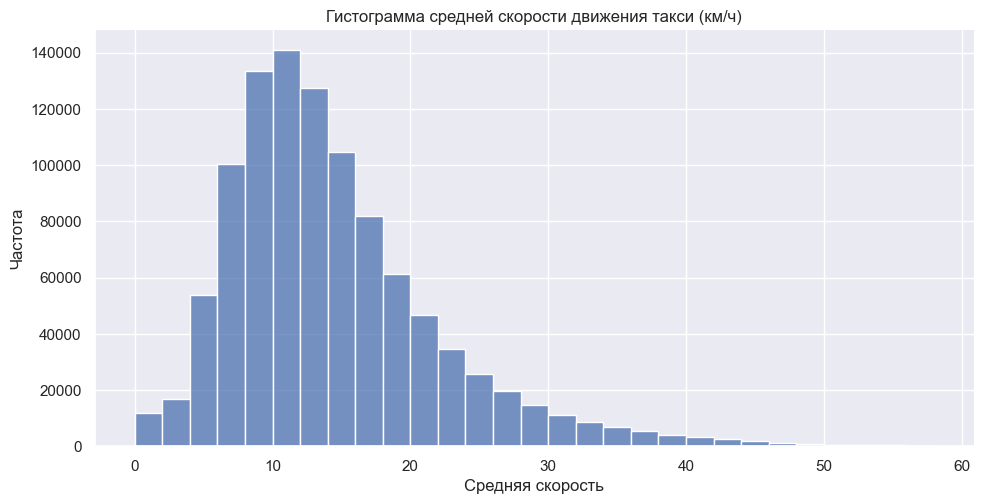

In [35]:
sns.displot(x="v_mean", data=X_train, bins=range(0, 60, 2), aspect=2, kde=False)
plt.title('Гистограмма средней скорости движения такси (км/ч)')
plt.xlabel('Средняя скорость')
plt.ylabel('Частота');

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

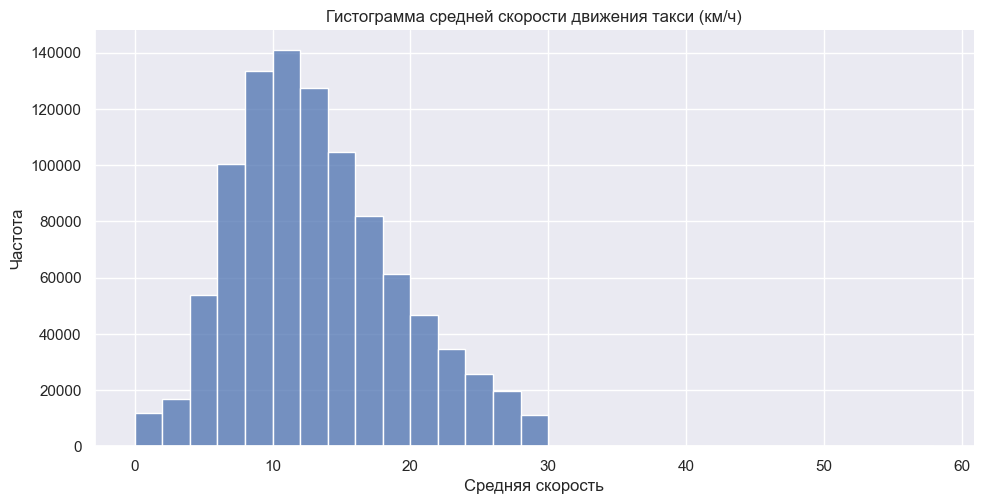

In [36]:
sns.displot(x="v_mean", data=X_train[X_train["v_mean"] < np.quantile(X_train["v_mean"], 0.95)], bins=range(0, 60, 2), aspect=2, kde=False)
plt.title('Гистограмма средней скорости движения такси (км/ч)')
plt.xlabel('Средняя скорость')
plt.ylabel('Частота');

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

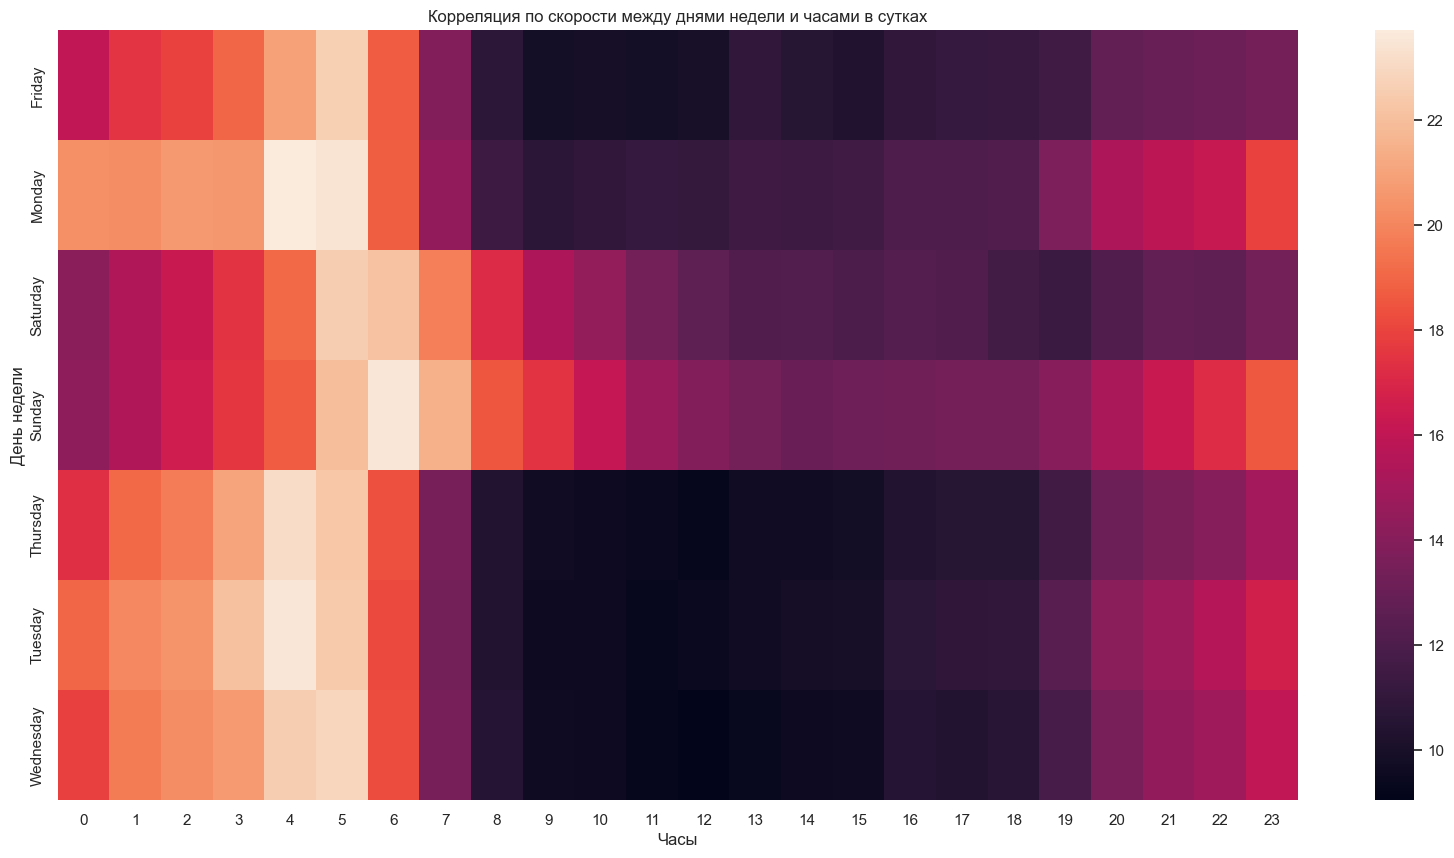

In [37]:
med_h = X_train.groupby(["day_of_week", "hour"], as_index=False)["v_mean"].median()
plt.figure(figsize=(20, 10))
sns.heatmap(med_h.pivot(index='day_of_week', columns='hour', values='v_mean'))
plt.title('Корреляция по скорости между днями недели и часами в сутках')
plt.xlabel('Часы')
plt.ylabel('День недели');

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Потому что при вычислении скорости мы использовали таргет. В связи с этим модель "подсмотрит" в таргет через переменную скорости и переобучится

In [38]:
X_train.drop("v_mean", axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Минимальна в будние дни с 08:00 до 18:00, максимальна во все дни с 04:00 до 06:00

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [39]:
work_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
mask = ((X_train['day_of_week'].isin(work_days)) & (X_train["hour"] >= 8) & (X_train["hour"] <= 18))
X_train["traffic"] = 0
X_train.loc[mask, "traffic"] = 1
X_train["free_road"] = 0
X_train.loc[~mask, "free_road"] = 1

mask = ((X_test['day_of_week'].isin(work_days)) & (X_test["hour"] >= 8) & (X_test["hour"] <= 18))
X_test["traffic"] = 0
X_test.loc[mask, "traffic"] = 1
X_test["free_road"] = 0
X_test.loc[~mask, "free_road"] = 1

mask = ((df_test['day_of_week'].isin(work_days)) & (df_test["hour"] >= 8) & (df_test["hour"] <= 18))
df_test["traffic"] = 0
df_test.loc[mask, "traffic"] = 1
df_test["free_road"] = 0
df_test.loc[~mask, "free_road"] = 1

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [40]:
# 40.749793644134414, -73.98592679700732 # Empire State Building 
# 40.78301353141516, -73.96583046759106 # Central park
X_train['from_ESB'] = (np.abs(X_train['pickup_latitude'] - 40.749793644134414) <= 0.01) & (np.abs(X_train['pickup_longitude'] + 73.98592679700732) <= 0.01)
X_train['to_ESB'] = (np.abs(X_train['dropoff_latitude'] - 40.749793644134414) <= 0.01) & (np.abs(X_train['dropoff_longitude'] + 73.98592679700732) <= 0.01)
X_test['from_ESB'] = (np.abs(X_test['pickup_latitude'] - 40.749793644134414) <= 0.01) & (np.abs(X_test['pickup_longitude'] + 73.98592679700732) <= 0.01)
X_test['to_ESB'] = (np.abs(X_test['dropoff_latitude'] - 40.749793644134414) <= 0.01) & (np.abs(X_test['dropoff_longitude'] + 73.98592679700732) <= 0.01)

X_train['from_CP'] = (np.abs(X_train['pickup_latitude'] - 40.78301353141516) <= 0.02) & (np.abs(X_train['pickup_longitude'] + 73.96583046759106) <= 0.02)
X_train['to_CP'] = (np.abs(X_train['dropoff_latitude'] - 40.78301353141516) <= 0.02) & (np.abs(X_train['dropoff_longitude'] + 73.96583046759106) <= 0.02)
X_test['from_CP'] = (np.abs(X_test['pickup_latitude'] - 40.78301353141516) <= 0.02) & (np.abs(X_test['pickup_longitude'] + 73.96583046759106) <= 0.02)
X_test['to_CP'] = (np.abs(X_test['dropoff_latitude'] - 40.78301353141516) <= 0.02) & (np.abs(X_test['dropoff_longitude'] + 73.96583046759106) <= 0.02)

df_test['from_ESB'] = (np.abs(df_test['pickup_latitude'] - 40.749793644134414) <= 0.01) & (np.abs(df_test['pickup_longitude'] + 73.98592679700732) <= 0.01)
df_test['to_ESB'] = (np.abs(df_test['dropoff_latitude'] - 40.749793644134414) <= 0.01) & (np.abs(df_test['dropoff_longitude'] + 73.98592679700732) <= 0.01)
df_test['from_CP'] = (np.abs(df_test['pickup_latitude'] - 40.78301353141516) <= 0.02) & (np.abs(df_test['pickup_longitude'] + 73.96583046759106) <= 0.02)
df_test['to_CP'] = (np.abs(df_test['dropoff_latitude'] - 40.78301353141516) <= 0.02) & (np.abs(df_test['dropoff_longitude'] + 73.96583046759106) <= 0.02)

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

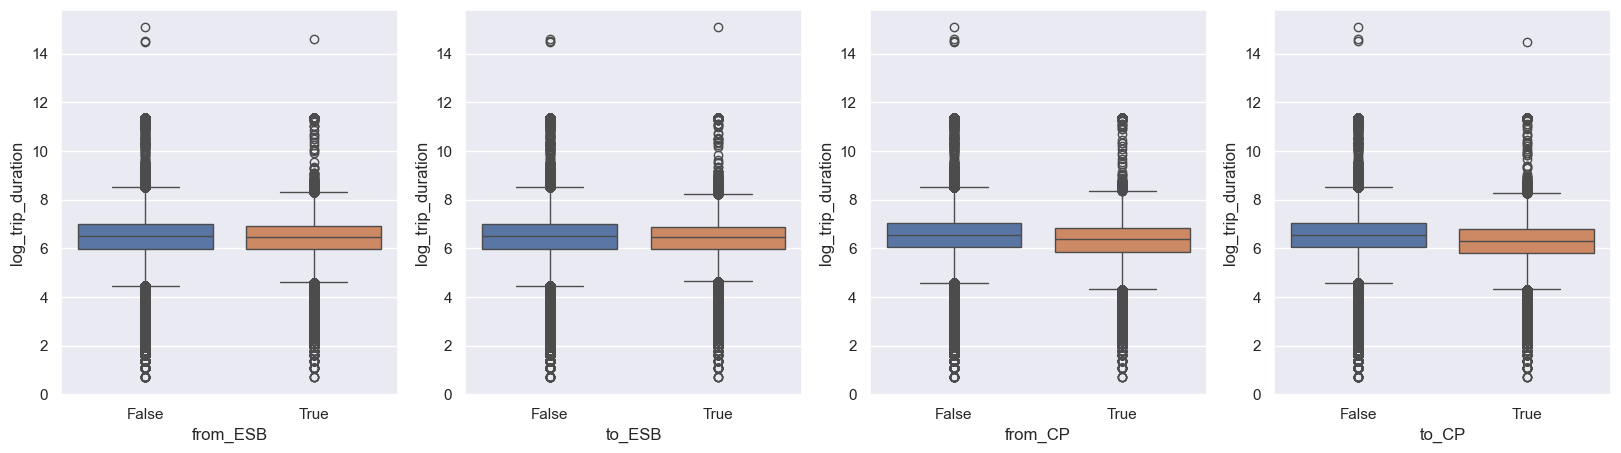

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="from_ESB", y="log_trip_duration", data=X_train, ax=axes[0], hue="from_ESB", legend=False)
sns.boxplot(x="to_ESB", y="log_trip_duration", data=X_train, ax=axes[1], hue="to_ESB", legend=False)
sns.boxplot(x="from_CP", y="log_trip_duration", data=X_train, ax=axes[2], hue="from_CP", legend=False)
sns.boxplot(x="to_CP", y="log_trip_duration", data=X_train, ax=axes[3], hue="to_CP", legend=False);

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Очень много выбросов, поэтому думаю, что нет

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [42]:
X_train.drop("log_trip_duration", axis=1, inplace=True)

In [43]:
X_test.drop("log_trip_duration", axis=1, inplace=True)

In [44]:
numeric = ["anomaly1", "anomaly2", "distance_haversine", "log_haversine", "traffic", "free_road", "from_ESB", "to_ESB", "from_CP", "to_CP"]
categorical = ["date", "hour", "day_of_week", "month"]

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)])

pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer),('L2_regression', Ridge())])
ridge = pipeline.fit(pd.concat([X_train[numeric + categorical], X_test[numeric + categorical]]), pd.concat([y_train, y_test]))
y_pred = ridge.predict(df_test[numeric + categorical])

In [45]:
df_test["trip_duration"] = np.expm1(y_pred)

In [46]:
df_test[["id", "trip_duration"]].to_csv("new_york_taxi.csv", index=False)

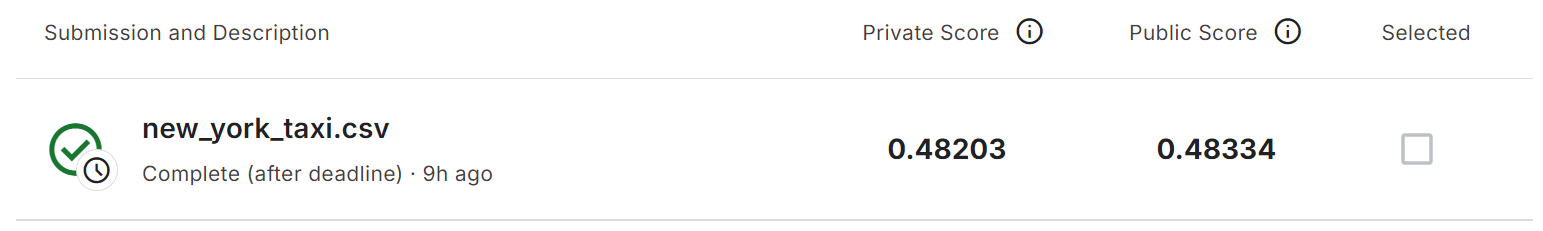

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным \
Один вендор может предоставлять услуги более качественно, чем другой

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [47]:
X_train["vendor_id"].nunique(), X_train["passenger_count"].nunique(), X_train["store_and_fwd_flag"].nunique()

(2, 9, 2)

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [48]:
X_train["log_trip_duration"] = y_train
# Снова возвращаем в X_train таргет

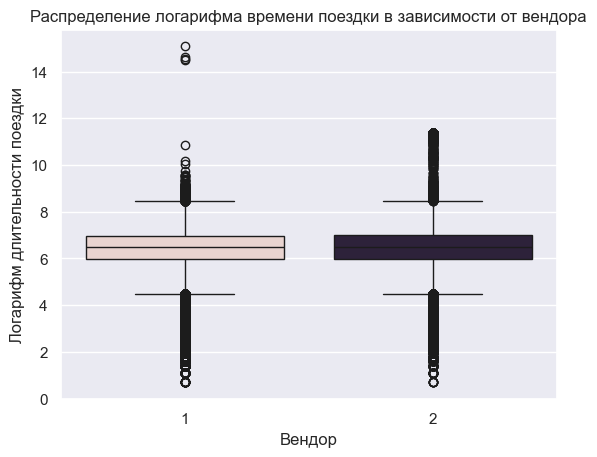

In [49]:
sns.boxplot(x='vendor_id', y='log_trip_duration', hue='vendor_id', data=X_train, legend=False)
plt.title('Распределение логарифма времени поездки в зависимости от вендора')
plt.ylabel('Логарифм длительности поездки')
plt.xlabel('Вендор');

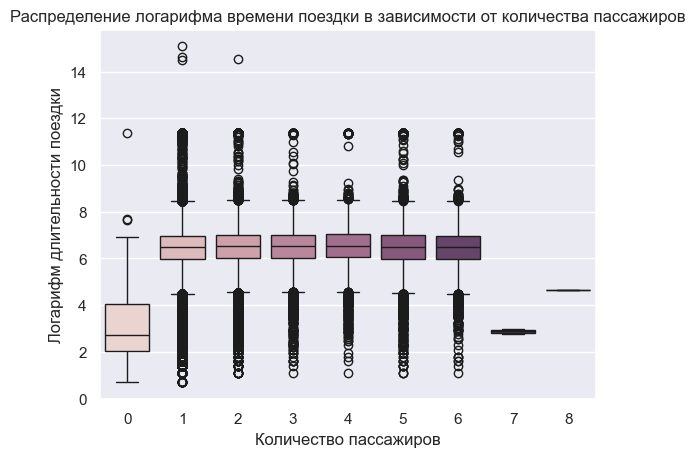

In [50]:
sns.boxplot(x='passenger_count', y='log_trip_duration', hue='passenger_count', data=X_train, legend=False)
plt.title('Распределение логарифма времени поездки в зависимости от количества пассажиров')
plt.ylabel('Логарифм длительности поездки')
plt.xlabel('Количество пассажиров');

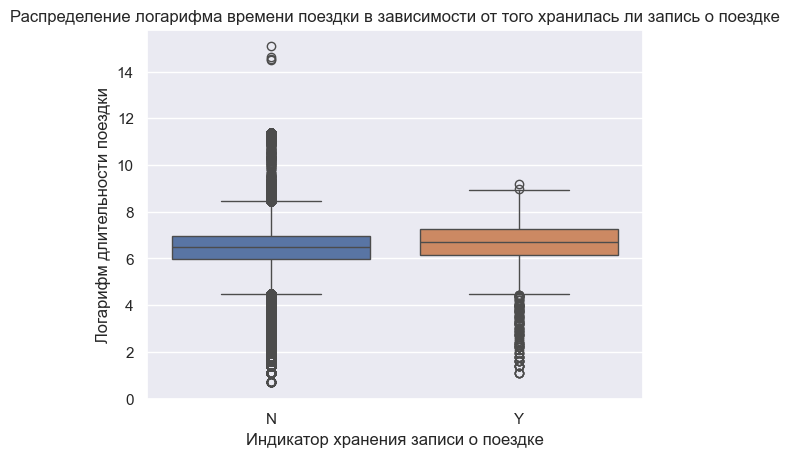

In [51]:
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', hue='store_and_fwd_flag', data=X_train, legend=False)
plt.title('Распределение логарифма времени поездки в зависимости от того хранилась ли запись о поездке')
plt.ylabel('Логарифм длительности поездки')
plt.xlabel('Индикатор хранения записи о поездке');

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [52]:
X_train["vendor_id"] = X_train["vendor_id"].map({1: 1, 2: 0})
X_train["store_and_fwd_flag"] = X_train["store_and_fwd_flag"].map({"Y": 1, "N": 0})
X_test["vendor_id"] = X_test["vendor_id"].map({1: 1, 2: 0})
X_test["store_and_fwd_flag"] = X_test["store_and_fwd_flag"].map({"Y": 1, "N": 0})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными? \
Интересным является лишь случай, когда было 0 пассажиров, возможно он и повлияет

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [53]:
X_train.drop("log_trip_duration", axis=1, inplace=True)
numeric = ["anomaly1", "anomaly2", "distance_haversine", "log_haversine", "traffic", "free_road", "from_ESB", 
           "to_ESB", "from_CP", "to_CP", "vendor_id", "passenger_count", "store_and_fwd_flag"]
categorical = ["date", "hour", "day_of_week", "month"]

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)])

pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer),('L2_regression', Ridge())])
ridge = pipeline.fit(X_train[numeric + categorical], y_train)
y_pred = ridge.predict(X_test[numeric + categorical])
print(f"RMSE = {mean_squared_error(y_pred, y_test, squared=False):.3f}")

RMSE = 0.486


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных. \
Метрика не улучшилась, => выбрасываем переменные

In [54]:
X_train.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag'], axis=1, inplace=True)
X_test.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag'], axis=1, inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

Гистограмму времени поездки мы строили в самом начале

In [55]:
X_train["log_trip_duration"] = y_train
# Снова возвращаем в X_train таргет

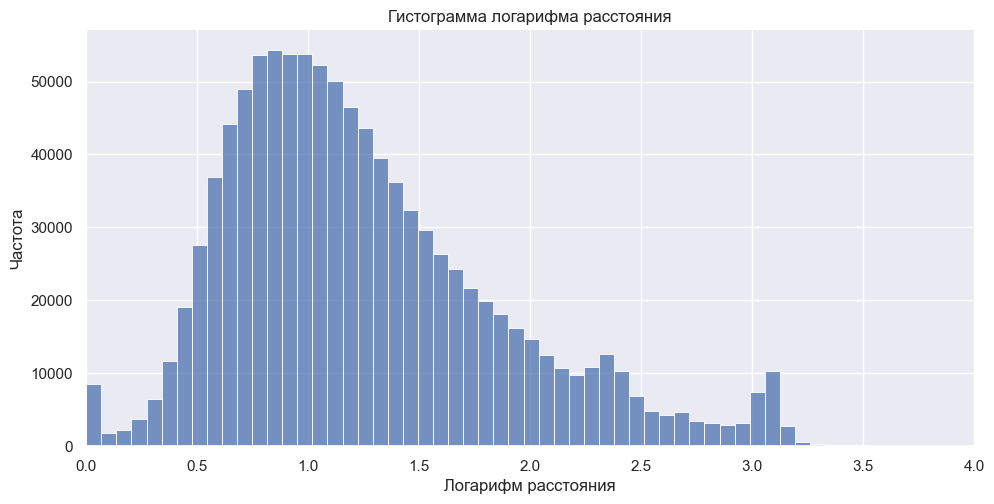

In [56]:
sns.displot(X_train['log_haversine'], bins=100, aspect=2, kde=False)
plt.title('Гистограмма логарифма расстояния')
plt.xlabel('Логарифм расстояния')
plt.ylabel('Частота')
plt.xlim([0, 4]);

In [57]:
X_train = X_train[X_train['log_trip_duration'] > np.quantile(X_train['log_trip_duration'], 0.03)]
X_train = X_train[X_train['log_haversine'] < np.quantile(X_train['log_haversine'], 0.95)]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [58]:
X_train["date"].value_counts()

date
2016-04-09    6421
2016-03-05    6260
2016-04-16    6233
2016-01-30    6076
2016-04-02    6055
              ... 
2016-01-25    3936
2016-01-03    3925
2016-05-30    3384
2016-01-24    2204
2016-01-23    1076
Name: count, Length: 182, dtype: int64

In [59]:
X_train["day_of_week"].value_counts()

day_of_week
Friday       144721
Saturday     142971
Thursday     141180
Wednesday    136518
Tuesday      131563
Sunday       123939
Monday       119690
Name: count, dtype: int64

In [60]:
X_train["hour"].value_counts()

hour
18    59237
19    59185
21    54409
20    54224
22    52107
17    49728
14    47484
12    46918
13    46159
15    46060
11    44942
9     44629
23    44568
8     43895
10    42901
16    40944
7     35839
0     33953
1     24562
6     20280
2     17782
3     13116
4      9254
5      8406
Name: count, dtype: int64

In [61]:
X_train["month"].value_counts()

month
March       165173
April       162639
May         159404
February    153968
June        151065
January     148333
Name: count, dtype: int64

В категориальных переменных значения достаточно сбалансированы, поэтому не вижу смысла удалять из них что-то

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [62]:
y_train = X_train["log_trip_duration"]
X_train.drop("log_trip_duration", axis=1, inplace=True)
numeric = ["anomaly1", "anomaly2", "distance_haversine", "log_haversine", "traffic", "free_road", "from_ESB", "to_ESB", "from_CP", "to_CP"]
categorical = ["date", "hour", "day_of_week", "month"]

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)])

pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer), ('L2_regression', Ridge())])
ridge = pipeline.fit(X_train[numeric + categorical], y_train)
y_pred = ridge.predict(X_test[numeric + categorical])
print(f"RMSE = {mean_squared_error(y_pred, y_test, squared=False):.3f}")

RMSE = 0.504


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте количество признаков до и после кодирования категориальных признаков.

In [63]:
numeric = ["anomaly1", "anomaly2", "distance_haversine", "log_haversine", "traffic", "free_road", "from_ESB", "to_ESB", "from_CP", "to_CP"]
categorical = ["date", "hour", "day_of_week", "month"]

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)])
print(f"Количество признаков до OHE: {X_train[numeric + categorical].shape[1]}")
print(f"Количество признаков после OHE: {column_transformer.fit_transform(X_train[numeric + categorical]).shape[1]}")

Количество признаков до OHE: 14
Количество признаков после OHE: 229


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше? \
RMSE сильно лучше у Ridge

In [64]:
from sklearn.linear_model import Lasso

In [65]:
numeric = ["anomaly1", "anomaly2", "distance_haversine", "log_haversine", "traffic", "free_road", "from_ESB", "to_ESB", "from_CP", "to_CP"]
categorical = ["date", "hour", "day_of_week", "month"]

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)])

pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer), ('L1_regression', Lasso())])
ridge = pipeline.fit(X_train[numeric + categorical], y_train)
y_pred = ridge.predict(X_test[numeric + categorical])
print(f"RMSE = {mean_squared_error(y_pred, y_test, squared=False):.3f}")

RMSE = 0.796


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
numeric = ["anomaly1", "anomaly2", "distance_haversine", "log_haversine", "traffic", "free_road", "from_ESB", "to_ESB", "from_CP", "to_CP"]
categorical = ["date", "hour", "day_of_week", "month"]

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)])
pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer), ('L2_regression', Ridge())])
params = {"L2_regression__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gcv1 = GridSearchCV(pipeline, params, n_jobs=-1, cv=5, scoring="neg_root_mean_squared_error", verbose=1)
gcv1.fit(X_train[numeric + categorical], y_train)


print(f"Лучший alpha = {gcv1.best_params_["L2_regression__alpha"]}")
rmse1 = mean_squared_error(gcv1.best_estimator_.predict(X_test[numeric + categorical]), y_test, squared=False)
print(f"Ridge RMSE = {rmse1:.3f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Лучший alpha = 10
Ridge RMSE = 0.503


In [68]:
numeric = ["anomaly1", "anomaly2", "distance_haversine", "log_haversine", "traffic", "free_road", "from_ESB", "to_ESB", "from_CP", "to_CP"]
categorical = ["date", "hour", "day_of_week", "month"]

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                        ('scaling', StandardScaler(), numeric)])
pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer), ('L1_regression', Lasso())])
params = {"L1_regression__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gcv2 = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, cv=5, scoring="neg_root_mean_squared_error", verbose=1)
gcv2.fit(X_train[numeric + categorical], y_train)


print(f"Лучший alpha = {gcv2.best_params_["L1_regression__alpha"]}")
rmse2 = mean_squared_error(gcv2.best_estimator_.predict(X_test[numeric + categorical]), y_test, squared=False)
print(f"Lasso RMSE = {rmse2:.3f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Лучший alpha = 0.001
Lasso RMSE = 0.500


Сохраните наилучшее значение, как бенчмарк на будущее

In [69]:
best_rmsle = rmse2

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [70]:
from tqdm.notebook import tqdm

In [71]:
w = []
for alpha in tqdm(params["L1_regression__alpha"]):
    pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer), ('L1_regression', Lasso(alpha))])
    pipeline.fit(X_train[numeric + categorical], y_train)
    weights = pipeline.named_steps["L1_regression"].coef_
    zero_count = np.sum(weights == 0)
    w.append(zero_count)
    print(f"alpha = {alpha},\tnumber of zero weights: {zero_count},\tRMSE = {mean_squared_error(pipeline.predict(X_test[numeric + categorical]), y_test, squared=False):.3f}")

  0%|          | 0/7 [00:00<?, ?it/s]

alpha = 0.001,	number of zero weights: 188,	RMSE = 0.500
alpha = 0.01,	number of zero weights: 221,	RMSE = 0.508
alpha = 0.1,	number of zero weights: 226,	RMSE = 0.543
alpha = 1,	number of zero weights: 229,	RMSE = 0.796
alpha = 10,	number of zero weights: 229,	RMSE = 0.796
alpha = 100,	number of zero weights: 229,	RMSE = 0.796
alpha = 1000,	number of zero weights: 229,	RMSE = 0.796


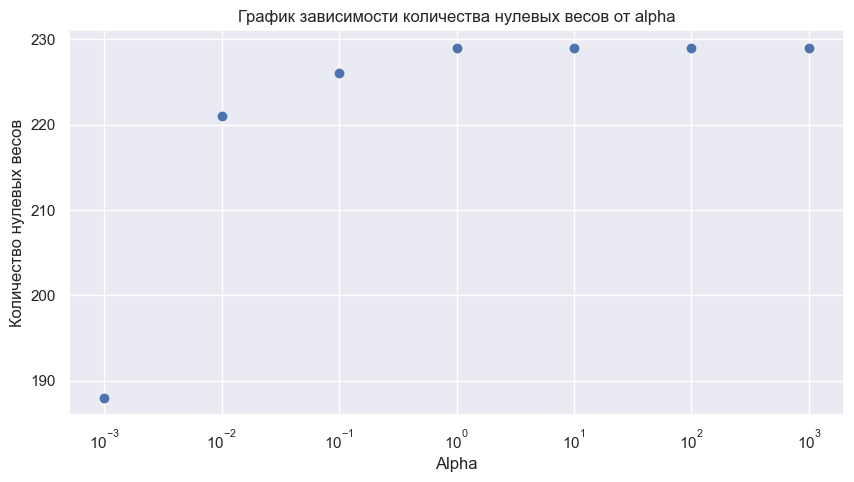

In [72]:
plt.figure(figsize=(10, 5))
plt.scatter(params["L1_regression__alpha"], w)
plt.xscale('log')
plt.title('График зависимости количества нулевых весов от alpha')
plt.xlabel('Alpha')
plt.ylabel('Количество нулевых весов');

На всех alpha количество нулевых признаков > половины, при этом мы не теряем в качестве при alpha == 0.001